# CHICHEWA  Automatic Speech Recognition (ASR) Benchmarking SAT models (MMS and Whisper) without fine-tuning.
----
In this experiment, we assess the performance metrics of two different Automatic Speech Recognition (ASR) models: the MMS model developed by Facebook and the Whisper model by OpenAI. The evaluation focuses on *Chichewa* langauge as well as two closely related languages: *Swahili* (SW) and *Shona* (SH).

Initially, we load the dataset containing **2432** audio files **(totaly 20.5 Hours)** and their respective transcripts. Subsequently, we carry out preprocessing and store the processed data for re-use. Subsequently, we  split the data into 80% Training and 20% validation. The training spans over 4000 steps on google colab A100 GPU (40 GB) and we report the Word error Rate (WER) and loss. The checkpoints are saved within each model name in the working directory.

### The resources used together with the hyperparameter are displayed below
- **For MMS model**:  https://huggingface.co/blog/mms_adapters Automated Speech Recognition, the checkpoint and logs  [here](https://drive.google.com/drive/folders/1_nhfufL6YX9iD-yLLai9PvbWXjuCI-4G?usp=sharing)
- **For Whisper**: https://openai.com/research/whisper the checkpoints and logs [here](https://drive.google.com/drive/folders/1--tgm2wmgT0fBCztD6lsxCUwJI-zTG_a?usp=sharing)



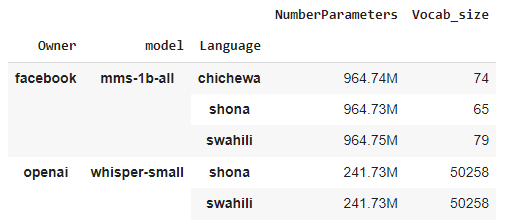

**Note that** The preprocessed data (time-consuming) encompassing  features extraction  and tokenize  are saved in working  directory.   

**Results** The study outcomes are displayed below, and the code is at the end of this notebook.


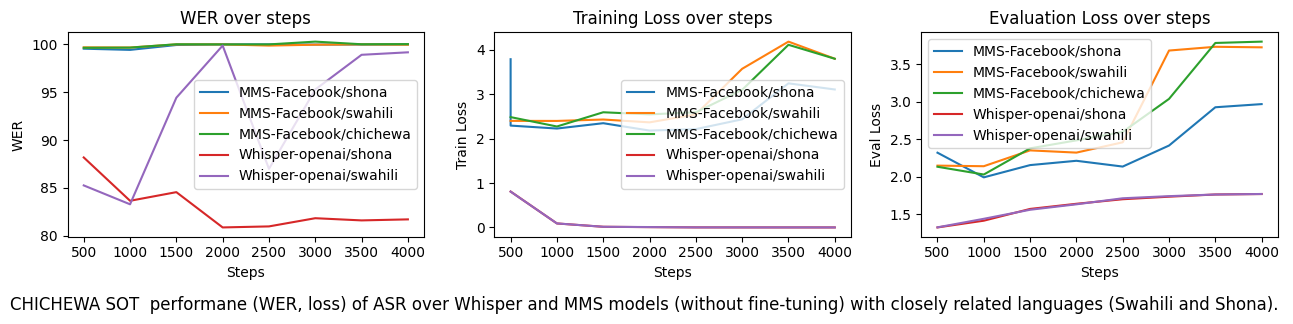



# Python setup

In [ ]:
!pip install tokenizers
# !pip install transformers
!pip install git+https://github.com/huggingface/transformers
!pip install librosa
!pip install datasets>=2.6.1
!pip install evaluate>=0.30
!pip install jiwer
!pip install gradio
!pip install accelerate>=0.20.1

This script is primarily focused on directory management in a Google Colab environment, especially within a user's Google Drive. It sets up directories for both datasets and pretrained models related to languages **Swahili** and **Shona**. For different   models, simply set the following  variables
- PRETRAINED_MODEL_ID="mms-1b-all"  and RELEASED_BY="facebook" for **MMS model**
- PRETRAINED_MODEL_ID="whisper-small"  and RELEASED_BY="openai" for **Whisper model**



In [ ]:
# Import necessary libraries
from google.colab import drive
import os
from pathlib import Path

# Mount Google Drive to Colab environment
drive.mount('/content/drive/', force_remount=True)

# Define the desired directory within Google Drive to work from
desired_directory = '/content/drive/My Drive/CHICHEWA_WORKSPACE'

# Check if the directory exists within Google Drive; if not, create it
if not os.path.exists(desired_directory):
    os.makedirs(desired_directory)

# Set the current working directory to the specified directory
os.chdir(desired_directory)

# Define the path for the Chichewa audio dataset
AUDIO_FOLDERS_DATASET = Path.cwd().joinpath('data', 'chichewa-speech-data', 'chich-audio-transcript-files-v1-30sec-sample')

# Define some constants for pretrained models
PRETRAINED_MODEL_ID = "mms-1b-all" # can  also be whisper-small/ whisper-medium
RELEASED_BY = "facebook"  # can be "facebook" or "openai"
PRETRAINED_LAN_SW = "swahili"
PRETRAINED_LAN_SH = "shona"
PRETRAINED_LAN_CHICHE = "chichewa"
# PRETRAINED_LAN_SW = PRETRAINED_LAN_CHICHE

# Create dictionaries to map language names to their respective codes
LANG_TO_CODE = {"swahili": "SW", "shona": "SH"}
LANG_TO_CODE_F = {"swahili": "swh", "shona": "sna","chichewa":'nya'}  # codes specific for Facebook models

# Define directories for the Swahili and Shona pretrained models
DIR_MODELS_SW = Path.cwd().joinpath(PRETRAINED_MODEL_ID, PRETRAINED_LAN_SW)
DIR_MODELS_SH = Path.cwd().joinpath(PRETRAINED_MODEL_ID, PRETRAINED_LAN_SH)
DIR_MODELS_CHICHE = Path.cwd().joinpath(PRETRAINED_MODEL_ID, PRETRAINED_LAN_CHICHE)

# Create directories to save the Swahili and Shona models, if they don't exist
DIR_MODELS_SW.mkdir(parents=True, exist_ok=True)
DIR_MODELS_SH.mkdir(parents=True, exist_ok=True)
DIR_MODELS_CHICHE.mkdir(parents=True, exist_ok=True)

# Define directories for pre-processed audio dataset batches for Swahili and Shona
PREPROESS_AUDIO_FOLDERS_DATASET_BATCH_SW = Path.cwd().joinpath('data_chichewa-speech-data_pre-process_batch_SW', RELEASED_BY)
PREPROESS_AUDIO_FOLDERS_DATASET_BATCH_SH = Path.cwd().joinpath('data_chichewa-speech-data_pre-process_batch_SH', RELEASED_BY)
PREPROESS_AUDIO_FOLDERS_DATASET_BATCH_CHICHE = Path.cwd().joinpath('data_chichewa-speech-data_pre-process_batch_CHICHE', RELEASED_BY)

# Create directories for pre-processed audio dataset batches for Swahili and Shona and Chichewa, if they don't exist
PREPROESS_AUDIO_FOLDERS_DATASET_BATCH_SW.mkdir(parents=True, exist_ok=True)
PREPROESS_AUDIO_FOLDERS_DATASET_BATCH_SH.mkdir(parents=True, exist_ok=True)
PREPROESS_AUDIO_FOLDERS_DATASET_BATCH_CHICHE.mkdir(parents=True, exist_ok=True)

Mounted at /content/drive/


Load the models and processor (feature extraction and tokenizer)

In [ ]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration, Wav2Vec2ForCTC, AutoProcessor

def get_processor(lan, model_id="whisper-small", released_by="openai"):
    """
    Load the processor for the specified language and model.

    Parameters:
    - lan: Target language
    - model_id: Identifier of the model
    - released_by: The entity that released the model (e.g., "openai")

    Returns:
    - Processor for the specified model
    """
    if released_by == "openai":
        return WhisperProcessor.from_pretrained(f'{released_by}/{model_id}', language=lan, task="transcribe")
    else:
        return AutoProcessor.from_pretrained(f'{released_by}/{model_id}', target_lang=LANG_TO_CODE_F.get(lan))


def get_pre_trained_model(MODEL_ID, released_by="openai", language=None):
    """
    Load the pre-trained model.

    Parameters:
    - MODEL_ID: Identifier of the model
    - released_by: The entity that released the model
    - language: Target language

    Returns:
    - Pre-trained model
    """
    if released_by == "openai":
        model = WhisperForConditionalGeneration.from_pretrained(f"{released_by}/{MODEL_ID}")
        model.config.forced_decoder_ids = None
        model.config.suppress_tokens = []
    else:
        model = Wav2Vec2ForCTC.from_pretrained(f"{released_by}/{MODEL_ID}", target_lang=LANG_TO_CODE_F.get(language), ignore_mismatched_sizes=True)
    return model


# Load processors for Swahili and Shona. These processors handle feature extraction and tokenization.
PROCESSOR_SH = get_processor(PRETRAINED_LAN_SH, model_id=PRETRAINED_MODEL_ID, released_by=RELEASED_BY)
PROCESSOR_SW = get_processor(PRETRAINED_LAN_SW, model_id=PRETRAINED_MODEL_ID, released_by=RELEASED_BY)
PROCESSOR_CHICHE = get_processor(PRETRAINED_LAN_CHICHE, model_id=PRETRAINED_MODEL_ID, released_by=RELEASED_BY)

# Load pre-trained Whisper or MMS models for Swahili and Shona
MODEL_SW = get_pre_trained_model(PRETRAINED_MODEL_ID, released_by=RELEASED_BY, language=PRETRAINED_LAN_SW)
MODEL_SH = get_pre_trained_model(PRETRAINED_MODEL_ID, released_by=RELEASED_BY, language=PRETRAINED_LAN_SH)
MODEL_CHICHE = get_pre_trained_model(PRETRAINED_MODEL_ID, released_by=RELEASED_BY, language=PRETRAINED_LAN_CHICHE)

# Uncomment the below code if you want to initialize and train adapters. Adapters allow fine-tuning without modifying the pre-trained weights.
# MODEL_SW.init_adapter_layers()
# adapter_weights = MODEL_SW._get_adapters()
# for param in adapter_weights.values():
#     param.requires_grad = True

# MODEL_SH.init_adapter_layers()
# adapter_weights = MODEL_SH._get_adapters()
# for param in adapter_weights.values():
#     param.requires_grad = True


Some weights of the model checkpoint at facebook/mms-1b-all were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/mms-1b-all and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0']
You should probably TRAIN this model on a down-stream

The following cell can be skipped. Its primary purpose is to extract the hyperparameters of the model as well as the vocabulary size of the examined languages.

In [ ]:
import pandas as pd

Hyperparameters = pd.DataFrame(columns=['Owner', 'model','Language','NumberParameters','Vocab_size'])

PRETRAINED_MODEL_IDs = {'mms-1b-all':'facebook', 'whisper-small':'openai'}
MODEL_AND_LIST_LANGS = {'facebook':['swahili','shona','chichewa'], 'openai': ['swahili','shona'] }

for  PRETRAINED_MODEL_ID,RELEASED_BY in  PRETRAINED_MODEL_IDs.items():

  for PRETRAINED_LAN  in MODEL_AND_LIST_LANGS.get(RELEASED_BY) :
    # Load processors for Swahili and Shona. These processors handle feature extraction and tokenization.
    PROCESSOR = get_processor(PRETRAINED_LAN, model_id=PRETRAINED_MODEL_ID, released_by=RELEASED_BY)

    # Load pre-trained Whisper or MMS models for Swahili and Shona
    MODEL = get_pre_trained_model(PRETRAINED_MODEL_ID, released_by=RELEASED_BY, language=PRETRAINED_LAN)

    # Print the number of parameters and vocabulary size
    num_parameters = MODEL.num_parameters()

    vocab_size= PROCESSOR.tokenizer.vocab_size

    # create dataframe row and append in in the  pandas frame
    row = {'Owner': RELEASED_BY, 'model': PRETRAINED_MODEL_ID, 'Vocab_size':vocab_size, 'NumberParameters': MODEL.num_parameters(),'Language':PRETRAINED_LAN}
    Hyperparameters = Hyperparameters.append(row, ignore_index = True)

# funtion to  format the parameters column
def format_number(num):
    if num >= 1e9:
        return f'{num/1e9:.2f}B'
    elif num >= 1e6:
        return f'{num/1e6:.2f}M'
    else:
        return str(num)

# Applying the format_number function to the 'parameters' column
Hyperparameters['NumberParameters'] = Hyperparameters['NumberParameters'].apply(format_number)

Hyperparameters_group = Hyperparameters.groupby(['Owner','model','Language'])

# Saving the DataFrame to a CSV file
Hyperparameters.to_csv(f'{Path.cwd()}/{"_".join(list(PRETRAINED_MODEL_IDs.keys()))}_hyperparameters.csv', index=False)

Hyperparameters_group.first()


Some weights of the model checkpoint at facebook/mms-1b-all were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/mms-1b-all and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0']
You should probably TRAIN this model on a down-stream

NumberParameters  Vocab_size
Owner    model         Language                             
facebook mms-1b-all    chichewa          964.74M          74
                       shona             964.73M          65
                       swahili           964.75M          79
openai   whisper-small shona             241.73M       50258
                       swahili           241.73M       50258

Load the data and  preprocess. To ensure we don't have to re-run the time-consuming preprocessing steps; you simply save the  preprocessed data and you can start loading the data from there.

In [ ]:
from datasets import load_dataset, DatasetDict
from datasets import Audio

def prepare_dataset(batch, processor, released_by="openai"):
    """
    Process and prepare batches of audio data.

    Parameters:
    - batch: A batch from the dataset
    - processor: Processor to extract features and tokenize transcriptions
    - released_by: The entity that released the model (e.g., "openai" or facebook)

    Returns:
    - Processed batch
    """
    # Load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # Compute log-Mel input features from input audio array
    if released_by == "openai":
        batch["input_features"] = processor.feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]
    else:  # for facebook
        batch["input_values"] = processor.feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]

    # Encode target text to label ids
    batch["labels"] = processor.tokenizer(batch["transcription"]).input_ids # when using the Whisper Tokenizer object
    # batch["labels"] = tokenizer.encode(batch["transcription"], add_special_tokens=True).ids  # when using the trained tokenizer BPE
    return batch

# Load the dataset from an audio folder
common_voice = load_dataset("audiofolder", data_dir=str(AUDIO_FOLDERS_DATASET), split='train')
# Cast the audio column to a specified sampling rate
common_voice = common_voice.cast_column("audio", Audio(sampling_rate=16000))

# Map the dataset to the prepare_dataset function for processing
common_voice_batch_SW = common_voice.map(prepare_dataset, fn_kwargs={"processor": PROCESSOR_SW, 'released_by': RELEASED_BY}, num_proc=20)
common_voice_batch_SH = common_voice.map(prepare_dataset, fn_kwargs={"processor": PROCESSOR_SH, 'released_by': RELEASED_BY}, num_proc=20)
common_voice_batch_CHICHE = common_voice.map(prepare_dataset, fn_kwargs={"processor": PROCESSOR_CHICHE, 'released_by': RELEASED_BY}, num_proc=20)


# Save the processed datasets to disk for future use
common_voice_batch_SW.save_to_disk(str(PREPROESS_AUDIO_FOLDERS_DATASET_BATCH_SW))
common_voice_batch_SH.save_to_disk(str(PREPROESS_AUDIO_FOLDERS_DATASET_BATCH_SH))
common_voice_batch_CHICHE.save_to_disk(str(PREPROESS_AUDIO_FOLDERS_DATASET_BATCH_CHICHE))


Resolving data files:   0%|          | 0/2433 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map (num_proc=20):   0%|          | 0/2432 [00:00<?, ? examples/s]

Saving the dataset (0/5 shards):   0%|          | 0/2432 [00:00<?, ? examples/s]

Load the saved dataset

In [ ]:
import datasets

# Load the processed datasets from disk
common_voice_batch_SW = datasets.load_from_disk(str(PREPROESS_AUDIO_FOLDERS_DATASET_BATCH_SW))
common_voice_batch_SH = datasets.load_from_disk(str(PREPROESS_AUDIO_FOLDERS_DATASET_BATCH_SH))
common_voice_batch_CHICHE = datasets.load_from_disk(str(PREPROESS_AUDIO_FOLDERS_DATASET_BATCH_CHICHE))

Split the dataset and use 80% for training and 20% for evaluation

In [ ]:
# Splitting the dataset into train and test
common_voice_batch_SW_split = common_voice_batch_SW.train_test_split(test_size=0.2,seed=123456)
common_voice_batch_SH_split = common_voice_batch_SH.train_test_split(test_size=0.2,seed=123456)
common_voice_batch_CHICHE_split = common_voice_batch_CHICHE.train_test_split(test_size=0.2,seed=123456)

This callback function handles batches in your training loop. Just ensure that your processor's tokenizer and feature extractor methods (pad, etc.) work as expected.

In [ ]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union
import torch
import torch
from torch.nn.utils.rnn import pad_sequence
from contextlib import redirect_stdout

# Define a custom data collator for handling padding of batches for the speech-to-text task
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    # The collator is initialized with a processor (for feature extraction & tokenization) and the model provider name
    processor: Any
    released_by: str = "openai"

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # Handle audio inputs (either input_features or input_values) by padding them
        if self.released_by == "openai":
            input_features = [{"input_features": feature["input_features"]} for feature in features]
            batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")
        else:
            input_values = [{"input_values": feature["input_values"]} for feature in features]
            batch = self.processor.feature_extractor.pad(input_values, return_tensors="pt")

        # Tokenize and pad the label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # Adjust label padding, ensuring labels with no attention mask get a value of -100 (the ignored index)
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # If there's a BOS token at the start, remove it
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels
        return batch

# Create data collator instances for both Swahili and Shona
data_collator_SW = DataCollatorSpeechSeq2SeqWithPadding(processor=PROCESSOR_SW, released_by=RELEASED_BY)
data_collator_SH = DataCollatorSpeechSeq2SeqWithPadding(processor=PROCESSOR_SH, released_by=RELEASED_BY)
data_collator_CHICHE = DataCollatorSpeechSeq2SeqWithPadding(processor=PROCESSOR_CHICHE, released_by=RELEASED_BY)

These callbacks functions entail to  evaluluate the model's  performance (**WER metric**) during the training.

In [ ]:
from numpy import argmax

import evaluate
# Load Word Error Rate (WER) metric
metric = evaluate.load("wer")


# MMS model, the MMS model does not have softmax layer
def compute_metrics_MMS(pred, processor_model):
    # Extract the predicted logits from the prediction object
    pred_logits = pred.predictions

    # Convert logits to token IDs by taking the argument of the max value in logits across the last dimension
    pred_ids = argmax(pred_logits, axis=-1)

    # Replace ignore tokens (-100) with the padding token for label IDs
    pred.label_ids[pred.label_ids == -100] = processor_model.tokenizer.pad_token_id

    # Decode the predicted token IDs to strings
    pred_str = processor_model.batch_decode(pred_ids)

    # Decode the label token IDs to strings without grouping the tokens
    label_str = processor_model.batch_decode(pred.label_ids, group_tokens=False)

    # Compute the Word Error Rate (WER) for the predicted and true labels
    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    # Return the WER as a dictionary
    return {"wer": wer}

#for whisper model
def compute_metrics(pred, tokenizer_model):
    # Extract the predicted token IDs from the prediction object
    pred_ids = pred.predictions

    # Extract the label IDs from the prediction object
    label_ids = pred.label_ids

    # Replace ignore tokens (-100) with the padding token for label IDs
    label_ids[label_ids == -100] = tokenizer_model.pad_token_id

    # Decode the predicted token IDs to strings while skipping any special tokens
    pred_str = tokenizer_model.batch_decode(pred_ids, skip_special_tokens=True)

    # Decode the label token IDs to strings while skipping any special tokens
    label_str = tokenizer_model.batch_decode(label_ids, skip_special_tokens=True)

    # Compute the Word Error Rate (WER) for the predicted and true labels
    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    # Return the WER as a dictionary
    return {"wer": wer}


Set up the training arguments and trainer of the MMS/facebook  ASR  model  (it does not use Sequence to sequence  model)

In [ ]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, Trainer, TrainingArguments

# define the batch size
BATCH_SIZE = 8

# Define training arguments for the SW model
training_args_CHICHE = TrainingArguments(
    output_dir=str(DIR_MODELS_CHICHE),                             # Directory for storing trained model
    logging_dir=str(DIR_MODELS_CHICHE.joinpath('logs')),           # Directory for storing logs
    per_device_train_batch_size=BATCH_SIZE,                    # Training batch size per device
    gradient_accumulation_steps=1,                             # Number of update steps to accumulate before performing a backward/update pass
    learning_rate=1e-3,                                        # Learning rate
    warmup_steps=500,                                          # Number of warmup steps for learning rate scheduler
    max_steps=4000,                                            # Total number of training steps
    gradient_checkpointing=True,                               # Use gradient checkpointing to save memory
    fp16=True,                                                 # Use mixed precision training
    evaluation_strategy="steps",                               # Evaluate the model every 'eval_steps'
    per_device_eval_batch_size=BATCH_SIZE,                     # Evaluation batch size per device
    save_steps=500,                                            # Save the model every 'save_steps'
    eval_steps=500,                                            # Evaluate the model every 'eval_steps'
    logging_steps=25,                                          # Log every 'logging_steps'
    report_to=["tensorboard"],                                 # Report results to Tensorboard
    load_best_model_at_end=True,                               # Load the best model in terms of the specified metric at the end of training
    metric_for_best_model="wer",                               # Use WER (Word Error Rate) as the metric to determine the best model
    greater_is_better=False,                                   # Lower WER is better, hence set to False
    push_to_hub=False,                                         # Whether to push the model to HuggingFace hub
)

# Define training arguments for the SW model
training_args_SW = TrainingArguments(
    output_dir=str(DIR_MODELS_SW),                             # Directory for storing trained model
    logging_dir=str(DIR_MODELS_SW.joinpath('logs')),           # Directory for storing logs
    per_device_train_batch_size=BATCH_SIZE,                    # Training batch size per device
    gradient_accumulation_steps=1,                             # Number of update steps to accumulate before performing a backward/update pass
    learning_rate=1e-3,                                        # Learning rate
    warmup_steps=500,                                          # Number of warmup steps for learning rate scheduler
    max_steps=4000,                                            # Total number of training steps
    gradient_checkpointing=True,                               # Use gradient checkpointing to save memory
    fp16=True,                                                 # Use mixed precision training
    evaluation_strategy="steps",                               # Evaluate the model every 'eval_steps'
    per_device_eval_batch_size=BATCH_SIZE,                     # Evaluation batch size per device
    save_steps=500,                                            # Save the model every 'save_steps'
    eval_steps=500,                                            # Evaluate the model every 'eval_steps'
    logging_steps=25,                                          # Log every 'logging_steps'
    report_to=["tensorboard"],                                 # Report results to Tensorboard
    load_best_model_at_end=True,                               # Load the best model in terms of the specified metric at the end of training
    metric_for_best_model="wer",                               # Use WER (Word Error Rate) as the metric to determine the best model
    greater_is_better=False,                                   # Lower WER is better, hence set to False
    push_to_hub=False,                                         # Whether to push the model to HuggingFace hub
)

# Define training arguments for the SH model (similar to SW model, just different directories)
training_args_SH = TrainingArguments(
    output_dir=str(DIR_MODELS_SH),                             # Directory for storing trained model
    logging_dir=str(DIR_MODELS_SH.joinpath('logs')),            # Directory for storing logs
    per_device_train_batch_size=BATCH_SIZE,                    # Training batch size per device
    gradient_accumulation_steps=1,                             # Number of update steps to accumulate before performing a backward/update pass
    learning_rate=1e-3,                                        # Learning rate
    warmup_steps=500,                                          # Number of warmup steps for learning rate scheduler
    max_steps=4000,                                            # Total number of training steps
    gradient_checkpointing=True,                               # Use gradient checkpointing to save memory
    fp16=True,                                                 # Use mixed precision training
    evaluation_strategy="steps",                               # Evaluate the model every 'eval_steps'
    per_device_eval_batch_size=BATCH_SIZE,                     # Evaluation batch size per device
    save_steps=500,                                            # Save the model every 'save_steps'
    eval_steps=500,                                            # Evaluate the model every 'eval_steps'
    logging_steps=25,                                          # Log every 'logging_steps'
    report_to=["tensorboard"],                                 # Report results to Tensorboard
    load_best_model_at_end=True,                               # Load the best model in terms of the specified metric at the end of training
    metric_for_best_model="wer",                               # Use WER (Word Error Rate) as the metric to determine the best model
    greater_is_better=False,                                   # Lower WER is better, hence set to False
    push_to_hub=False,                                         # Whether to push the model to HuggingFace hub
)

# Initialize the trainer for the SW model
trainer_CHICHE = Trainer(
    args=training_args_CHICHE,                                      # Training arguments
    model=MODEL_CHICHE,                                             # Model to train
    train_dataset=common_voice_batch_CHICHE_split["train"],         # Training dataset
    eval_dataset=common_voice_batch_CHICHE_split["test"],           # Evaluation dataset
    data_collator=data_collator_CHICHE,                             # Data collator to use
    compute_metrics=lambda pre: compute_metrics_MMS(pre, PROCESSOR_CHICHE),  # Function to compute metrics
    tokenizer=PROCESSOR_SW.feature_extractor,                   # Tokenizer for the dataset
)

# Initialize the trainer for the SW model
trainer_SW = Trainer(
    args=training_args_SW,                                      # Training arguments
    model=MODEL_SW,                                             # Model to train
    train_dataset=common_voice_batch_SW_split["train"],         # Training dataset
    eval_dataset=common_voice_batch_SW_split["test"],           # Evaluation dataset
    data_collator=data_collator_SW,                             # Data collator to use
    compute_metrics=lambda pre: compute_metrics_MMS(pre, PROCESSOR_SW),  # Function to compute metrics
    tokenizer=PROCESSOR_SW.feature_extractor,                   # Tokenizer for the dataset
)


# Initialize the trainer for the SH model
trainer_SH = Trainer(
    args=training_args_SH,                                      # Training arguments
    model=MODEL_SH,                                             # Model to train
    train_dataset=common_voice_batch_SH_split["train"],         # Training dataset
    eval_dataset=common_voice_batch_SH_split["test"],           # Evaluation dataset
    data_collator=data_collator_SH,                             # Data collator to use
    compute_metrics=lambda pre: compute_metrics_MMS(pre, PROCESSOR_SH),  # Function to compute metrics
    tokenizer=PROCESSOR_SH.feature_extractor,                   # Tokenizer for the dataset
)



Set up the training arguments and trainer of the Whisper ASR model, it uses sequence to sequence model

In [ ]:
from transformers import Seq2SeqTrainingArguments,Seq2SeqTrainer,Trainer,TrainingArguments

# define the batch size
BATCH_SIZE = 8

training_args_SW = Seq2SeqTrainingArguments(
    output_dir=str(DIR_MODELS_SW),
    # num_train_epochs = 50,
    logging_dir=str(DIR_MODELS_SW.joinpath('logs')),            ## change to a repo name of your choice
    per_device_train_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-3,
    warmup_steps=500,
    max_steps=4000, # 4000
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=BATCH_SIZE,
    predict_with_generate=True, # for openai only
    generation_max_length=225, # for openai only
    save_steps=500, # 1000
    eval_steps=500, # 1000
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=False, #push_to_hub=True default
)


training_args_SH = Seq2SeqTrainingArguments(
    output_dir=str(DIR_MODELS_SH),
    logging_dir=str(DIR_MODELS_SH.joinpath('logs')),            ## change to a repo name of your choice
    per_device_train_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-3,
    warmup_steps=500,
    max_steps=4000, # 4000
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=BATCH_SIZE,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=500, # 1000
    eval_steps=500, # 1000
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=False, #push_to_hub=True default
)

trainer_SW = Seq2SeqTrainer(
    args=training_args_SW,
    model=MODEL_SW,
    train_dataset=common_voice_batch_SW_split["train"],
    eval_dataset=common_voice_batch_SW_split["test"],
    data_collator=data_collator_SW,
    compute_metrics=lambda pre: compute_metrics(pre,PROCESSOR_SW.tokenizer) ,
    tokenizer=PROCESSOR_SW.feature_extractor,
)

trainer_SH = Seq2SeqTrainer(
    args=training_args_SH,
    model=MODEL_SH,
    train_dataset=common_voice_batch_SH_split["train"],
    eval_dataset=common_voice_batch_SH_split["test"],
    data_collator=data_collator_SH,
    compute_metrics=lambda pre: compute_metrics(pre,PROCESSOR_SW.tokenizer),
    tokenizer=PROCESSOR_SH.feature_extractor,
)


# Train the two  models, Swahili and Shona

In [ ]:
# Start training the Chichewa model
trainer_CHICHE.train()

# Start training the Shona model
trainer_SW.train()

# Once training is complete, delete the trainer to free up some memory
del trainer_SW

#Explicitly empty the GPU cache to ensure any tensors residing in the GPU memory are cleared out.
# This can help in ensuring that the subsequent training for `trainer_SW` has sufficient GPU memory.
torch.cuda.empty_cache()

# Start training the Shawilli model
trainer_SH.train()



/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Wer
500,2.482400,2.131669,99.647726
1000,2.270900,2.027972,99.663042
1500,2.591100,2.377149,100.015316
2000,2.544000,2.483968,100.000000
2500,2.590700,2.597172,100.000000
3000,3.095600,3.037132,100.291009
3500,4.108500,3.783695,100.015316
4000,3.794800,3.801553,100.030633


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

TrainOutput(global_step=4000, training_loss=2.8032529249191285, metrics={'train_runtime': 9354.3404, 'train_samples_per_second': 3.421, 'train_steps_per_second': 0.428, 'total_flos': 5.7952534741392105e+19, 'train_loss': 2.8032529249191285, 'epoch': 16.39})

# We can load the saved logs files

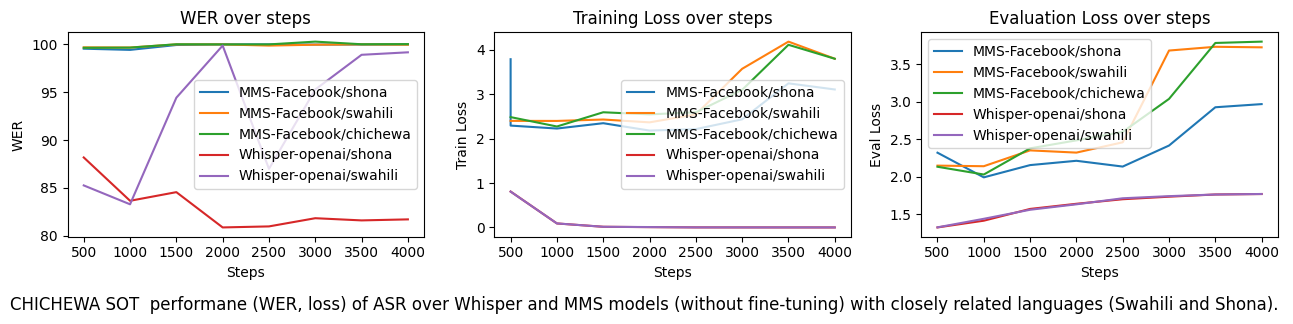

,Steps,WER_MMS-Facebook/shona,Train-Loss_MMS-Facebook/shona,Eval-Loss_MMS-Facebook/shona,WER_MMS-Facebook/swahili,Train-Loss_MMS-Facebook/swahili,Eval-Loss_MMS-Facebook/swahili,WER_MMS-Facebook/chichewa,Train-Loss_MMS-Facebook/chichewa,Eval-Loss_MMS-Facebook/chichewa,WER_Whisper-openai/shona,Train-Loss_Whisper-openai/shona,Eval-Loss_Whisper-openai/shona,WER_Whisper-openai/swahili,Train-Loss_Whisper-openai/swahili,Eval-Loss_Whisper-openai/swahili
0,500,99.551155,3.784300,2.319244,99.690453,2.397600,2.146743,99.647728,2.482400,2.131669,88.175835,0.808100,1.321842,85.250420,0.806400,1.323049
1,500,99.551155,2.291400,2.319244,99.690453,2.397600,2.146743,99.647728,2.482400,2.131669,88.175835,0.808100,1.321842,85.250420,0.806400,1.323049
2,1000,99.427330,2.225100,1.990089,99.674973,2.396300,2.138809,99.663040,2.270900,2.027972,83.642212,0.090400,1.411783,83.274620,0.090900,1.437073
3,1500,99.938087,2.345200,2.153732,100.000000,2.427900,2.350016,100.015320,2.591100,2.377149,84.545876,0.015600,1.568807,94.424873,0.015500,1.557626
4,2000,100.000000,2.179300,2.211254,100.000000,2.364100,2.320424,100.000000,2.544000,2.483968,80.854645,0.007500,1.637519,99.877472,0.009300,1.630399
5,2500,100.000000,2.211900,2.134130,99.876183,2.542800,2.457835,100.000000,2.590700,2.597172,80.961861,0.001800,1.698126,86.981163,0.002000,1.710998
6,3000,99.984520,2.432500,2.414635,99.969048,3.568700,3.682472,100.291008,3.095600,3.037132,81.819572,0.001400,1.732001,95.282585,0.001400,1.739300
7,3500,99.984520,3.241600,2.925591,100.000000,4.179900,3.732621,100.015320,4.108500,3.783695,81.589828,0.001100,1.761589,98.912544,0.001100,1.761124
8,4000,100.000000,3.103700,2.967621,99.969048,3.795400,3.725470,100.030632,3.794800,3.801553,81.697044,0.000900,1.767670,99.172920,0.000900,1.768206


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd
from functools import reduce

models_trained = {"mms-1b-all":"MMS-Facebook", "whisper-small":"Whisper-openai"}
Languages = {"shona":"SH","swahili":"SW",'chichewa':'nya'}
DIR_MODELS_BASE = Path.cwd()
DIR_MODELS_BASE = Path.cwd()

# range of steps to consider
STEPS = [500,1000,1500,2000,2500,3000,3500,4000]

def get_event_data(model, metric):
    log_dir = DIR_MODELS_BASE.joinpath(model, 'logs')
    event_acc = EventAccumulator(str(log_dir))
    event_acc.Reload()

    data = event_acc.Scalars(metric)
    values = [scalar.value for scalar in data  if scalar.step in STEPS ]
    steps = [scalar.step for scalar in data if scalar.step in STEPS ]

    return steps, values

# Plotting and displaying DataFrame
fig, axs = plt.subplots(1, 3, figsize=(13, 3))  # 3 plots: WER, train loss, eval loss
dfs = []  # List to store DataFrames

for model_name, _ in models_trained.items():
    for lang, _ in Languages.items():

        full_model_name = Path.cwd().joinpath(model_name,lang)

        if not full_model_name.exists():
          continue

        label_plot = f'{models_trained.get(model_name)}/{lang}'
        # Get WER, train and eval loss
        wer_steps, wer_values = get_event_data(full_model_name, 'eval/wer')
        train_loss_steps, train_loss_values = get_event_data(full_model_name, 'train/loss')
        eval_loss_steps, eval_loss_values = get_event_data(full_model_name, 'eval/loss')

        # Create DataFrames
        df_wer = pd.DataFrame({'Steps': wer_steps, f'WER_{label_plot}': wer_values})
        df_train_loss = pd.DataFrame({'Steps': train_loss_steps, f'Train-Loss_{label_plot}': train_loss_values})
        df_eval_loss = pd.DataFrame({'Steps': eval_loss_steps, f'Eval-Loss_{label_plot}': eval_loss_values})
        dfs.extend([df_wer, df_train_loss, df_eval_loss])  # Add to list

        # Plot WER
        axs[0].plot(wer_steps, wer_values, label=f"{label_plot}")
        axs[0].set_title("WER over steps")
        axs[0].set_xlabel("Steps")
        axs[0].set_ylabel("WER")
        axs[0].legend()

        # Plot train loss
        axs[1].plot(train_loss_steps, train_loss_values, label=f"{label_plot}")
        axs[1].set_title("Training Loss over steps")
        axs[1].set_xlabel("Steps")
        axs[1].set_ylabel("Train Loss")
        axs[1].legend()

        # Plot eval loss
        axs[2].plot(eval_loss_steps, eval_loss_values, label=f"{label_plot}")
        axs[2].set_title("Evaluation Loss over steps")
        axs[2].set_xlabel("Steps")
        axs[2].set_ylabel("Eval Loss")
        axs[2].legend()

plt.tight_layout()

# Adding caption below the figure
caption = "CHICHEWA SOT  performane (WER, loss) of ASR over Whisper and MMS models (without fine-tuning) with closely related languages (Swahili and Shona). "
fig.text(0.5, -0.05, caption, ha='center', fontsize=12, wrap=True)

# save the image with resolution dpi 600
# fig.savefig(f"{DIR_MODELS_BASE}/SAT_CHICHEWA_ASR.png", bbox_inches='tight', dpi=300)
fig.savefig(f"{DIR_MODELS_BASE}/SAT_CHICHEWA_ASR.png", bbox_inches='tight')
plt.show()

# Displaying the DataFrames below the plots
# Function to apply the style
def highlight_min(s):
    # is_min will be a boolean series where 'True' corresponds to the minimum value
    is_min = s == s.min()
    # We return a list of strings with 'font-weight: bold' where the minimum values are
    return ['font-weight: bold' if v else '' for v in is_min]

# Applying the style to the DataFrame
merged_df = reduce(lambda left, right: pd.merge(left, right, on='Steps', how='inner'), dfs)
styled_df = merged_df.style.apply(highlight_min)
styled_df

